<a href="https://colab.research.google.com/github/ErmakovSemen/Ermakov_prop1/blob/main/CP_Ermajkov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from tqdm import trange, tqdm
from numba import njit, prange, jit
import datetime
import time
from typing import Sequence


# %pip install ipython-autotime
# %load_ext autotime


In [3]:
@njit
def int2array(x: int, L: int) -> np.ndarray:
    """
    The int 2 array function converts the number x into a uint8 array.
    Arguments :
        x (int): The number to be converted.
        L (int): The length of the int8 array.
    Returns:
        res (np.ndarray): A uint8 array with the converted number x.
    """
    res = np.empty(L, dtype=np.int8)
    for i in prange(L):
        res[i] = (x & 1) * 2 - 1
        x = x >> 1
    return res

In [4]:
@njit(parallel = True)
def create_Matrix(y: int , Ly: int, Lx: int):
    """
    Run int2array with passed args (y, Lx*Ly)
    Arguments :
        x (int): The number to be converted.
        Lx (int): One of dims of spins matrix.
        Ly (int): One of dims of spins matrix.
    Returns:
        res (np.ndarray): A uint8 array with the converted number x.
    """
    return int2array(y, Lx*Ly)

In [89]:
@njit
def calculate_energy(sigma : np.ndarray): # Энергия одной матрицы
    """
    The energy calculation function increases the efficiency of a single matrix.
    Arguments:
        sigma (np.ndarray): A matrix for calculating regression.
    Returns:
        float: Calculated energy of the matrix.
    """
    Ly, Lx = sigma.shape
    total_energy = 0

    for i in prange(Lx):
        for j in prange(Ly):
            total_energy += - sigma[j, i] * (
                sigma[(j + 1) % Ly, i] + sigma[j, (i + 1) % Lx]
            )

    return total_energy #/ (Lx * Ly)


In [90]:
@njit(parallel = True)
def mean_energy_proto(Ly:int ,Lx: int, kT: float, spins : np.ndarray, spins_num) -> float: # средня энергия по Lx, Ly, kT
    """
    The mean_energy_proto function determines the calculation of the average energy for the specified sizes Lx, Ly, temperature kT and the spin array spins.
     E_mean - the average energy,
     Z - normalizing factor. For each spin from the spins array, the calculate_energy function calculates the energy E and then applies the np.exp function to calculate the exponent e.
     Then E_mean is summed with the product of E and e, and Z is summed with e.
     At the end, the function returns E_mean / Z.
     Arguments:
        Ly (int) : one of dims of spins matrix
        Lx (int) : one of dims of spins matrix
        kT (float) : current temerature
        spins (np.ndarray) : all possible spins variations
    """
    spin = int2array(spins_num, Lx*Ly)
    E_mean = 0
    Z = 0


    E = calculate_energy(spin.reshape(Ly,Lx))
    e = np.exp(-E/kT)
    E_mean += E * e
    Z += e

    return E_mean/Z

In [97]:
@njit(parallel = True)
def run_culc(Ly : int, Lx : int , kT : float) -> float:
    """
    Calculate the mean for a given lattice size and temperature.
    Args:
        Ly (int): one of dims of spins matrix
        Lx (int): one of dims of spins matrix
        kT (float): The product of Boltzmann's constant and temperature.
    Returns:
        float: The mean calculated energy .
    """

    # spins = np.empty(2**(Lx*Ly))
    # spins = []
    cum_sum_energy = 0
    Z = 0

    for y in prange(2**(Lx*Ly)):
        # spins.append(int2array(y, Lx*Ly))
        arr  = int2array(y, Lx*Ly).reshape(Lx,Ly)
        E = calculate_energy(arr)
        e = np.exp(-E/kT)
        cum_sum_energy += e*E
        Z += e

    return cum_sum_energy/Z/(Lx*Ly)

In [103]:
def visualisation(data):
    """
    Function for data visualization. (Gets [loc_diffusion_map, loc_temp_map, loc_points_data])
    Arguments: data - input data for visualization.
    Returns: None
    """

    plt.pcolormesh(data)
    plt.colorbar()
    plt.xlabel("Lx")
    plt.ylabel("kT")
    plt.show()
    return

In [113]:
N = 6
before = time.time()
Lx_lst = range(2,N)
kt_lst = range(10,51,1)
ans = np.zeros((len(kt_lst),len(Lx_lst)))

for x, Lx in enumerate(Lx_lst):
    for y,kT in enumerate(kt_lst):
        ans[y][x] = run_culc(Lx = Lx, Ly = 4, kT = kT/10)
after = time.time()

        # print(run_culc(Lx = Lx, Ly = 4, kT = kT/10))
print(f"time : {after - before}")

time : 12.146650552749634


In [119]:
for Lx in Lx_lst:
    print(f"Lx : {Lx}\n" ,ans[:,Lx - 2])

Lx : 2
 [-1.99509474 -1.98967862 -1.98074878 -1.96731117 -1.94851445 -1.92375828
 -1.89277291 -1.85565639 -1.81286316 -1.76514762 -1.71347563 -1.65892227
 -1.60257405 -1.5454491  -1.48844224 -1.43229537 -1.3775895  -1.3247523
 -1.27407538 -1.22573609 -1.17982015 -1.13634286 -1.09526756 -1.05652101
 -1.02000562 -0.98560898 -0.9532109  -0.92268862 -0.89392045 -0.86678827
 -0.84117913 -0.8169862  -0.79410926 -0.77245486 -0.75193626 -0.73247322
 -0.71399168 -0.69642337 -0.67970548 -0.66378023 -0.64859447]
Lx : 3
 [-1.99711779 -1.99383665 -1.98825271 -1.97949351 -1.96659182 -1.94853206
 -1.92432618 -1.89312223 -1.85433583 -1.80777902 -1.75375117 -1.69305981
 -1.62695673 -1.55700043 -1.48487836 -1.41223059 -1.34050963 -1.27089443
 -1.20425882 -1.14118312 -1.08199278 -1.02680913 -0.97560137 -0.92823315
 -0.88450084 -0.84416295 -0.80696158 -0.77263715 -0.7409381  -0.71162671
 -0.68448222 -0.65930219 -0.63590256 -0.61411702 -0.5937959  -0.57480491
 -0.55702372 -0.54034463 -0.52467121 -0.5099171

In [81]:
np.save("save", ans)

In [82]:
read = np.load("save.npy")

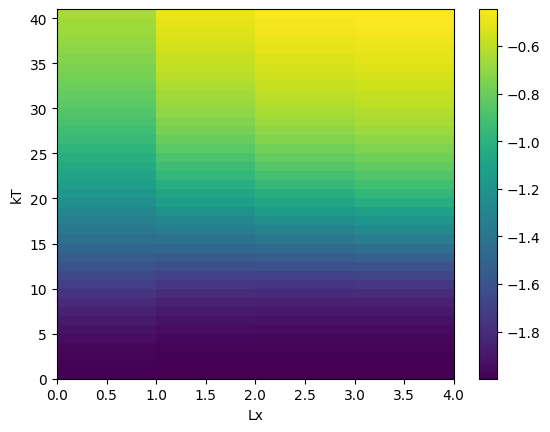

In [104]:
visualisation(ans)